In [1]:
# Importing the appropriate libraries
import keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import itertools
import os
import keras

In [2]:
# Initial settings
im_height = 224 
im_width = 224
batch_size = 32
epochs = 50
num_classes = 3
labels = ['1','2','3']
save_path = './save_weights/224/res50_224-{epoch:02d}-{val_accuracy:.2f}.h5'
save_json = './csv/res50_224.csv'

image_path = 'G:/dataset/seedling_classification_224/'
VERBOSE = 1
train_dir = image_path + "train"
val_dir = image_path + "val"
test_dir = image_path + "test"

In [3]:
# Data pre-processing
train_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
#     horizontal_flip=True,
#     vertical_flip=True,
)
val_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)
test_image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

In [4]:
# Generate dataset
train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           color_mode="rgb",
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
total_train = train_data_gen.n

val_data_gen = val_image_generator.flow_from_directory( directory=val_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                       color_mode="rgb",
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_val = val_data_gen.n

test_data_gen = test_image_generator.flow_from_directory( directory=test_dir,
                                                          batch_size=batch_size,
                                                          shuffle=False,
                                                         color_mode="rgb",
                                                          target_size=(im_height, im_width),
                                                          class_mode='categorical')
total_test = test_data_gen.n

Found 39172 images belonging to 3 classes.
Found 13059 images belonging to 3 classes.
Found 13059 images belonging to 3 classes.


In [5]:
# Building the model
covn_base = tf.keras.applications.ResNet50(weights='imagenet', include_top = False,
                                              input_shape=(im_height,im_width,3))
covn_base.trainable = False
model = tf.keras.Sequential([
        covn_base,
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units = 32, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation='softmax',
                              kernel_regularizer='l2'
                             )
    ])
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 2048)        8192      
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

In [6]:
# Building the model
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
# Monitor the change of 'val_loss', if the learning rate decays to 1/5 of the original one after four rounds of constant learning
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss', 
                                factor=0.2, 
                                patience=4, 
                                mode='auto',
                                verbose=VERBOSE
                             )

# Set the model save path and save the optimal model according to val_acc
checkpoint = ModelCheckpoint(
                                filepath=save_path,
                                monitor='val_accuracy', 
                                save_weights_only=True, 
                                save_best_only=True, 
                                mode='auto'
                            )
# Start training
history = model.fit(x=train_data_gen,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    verbose=VERBOSE,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/50
1224/1224 [==============================] - 131s 107ms/step - loss: 0.2164 - accuracy: 0.9300 - val_loss: 0.1126 - val_accuracy: 0.9678
Epoch 2/50
1224/1224 [==============================] - 130s 107ms/step - loss: 0.1322 - accuracy: 0.9581 - val_loss: 0.0953 - val_accuracy: 0.9711
Epoch 3/50
1224/1224 [==============================] - 132s 108ms/step - loss: 0.1126 - accuracy: 0.9643 - val_loss: 0.0725 - val_accuracy: 0.9798
Epoch 4/50
1224/1224 [==============================] - 130s 107ms/step - loss: 0.1027 - accuracy: 0.9669 - val_loss: 0.0688 - val_accuracy: 0.9809
Epoch 5/50
1224/1224 [==============================] - 122s 99ms/step - loss: 0.0943 - accuracy: 0.9702 - val_loss: 0.0719 - val_accuracy: 0.9803
Epoch 6/50
1224/1224 [==============================] - 120s 98ms/step - loss: 0.0878 - accuracy: 0.9722 - val_loss: 0.0600 - val_accuracy: 0.9844
Epoch 7/50
1224/1224 [==============================] - 121s 99ms/step - loss: 0.0825 - accuracy: 0.9736 - val_los

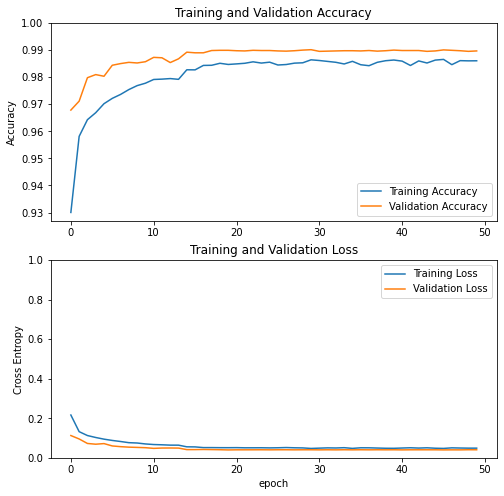

In [10]:
# Plotting model accuracy and loss variation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [7]:
# Load the best model in training
try:
    model.load_weights("./save_weights/224/res50/res50_224-30-0.99.h5")
    print("Loading model successfully")
except :    
    print("Failed to load model")

Loading model successfully


In [8]:
test_loss, test_acc = model.evaluate(val_data_gen)

print('\nVal accuracy:', test_acc)
print('\nVal loss:', test_loss)

409/409 [==============================] - 32s 77ms/step - loss: 0.0406 - accuracy: 0.9901

Val accuracy: 0.9901217818260193

Val loss: 0.04059712961316109


In [9]:
test_loss, test_acc = model.evaluate(test_data_gen)

print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

409/409 [==============================] - 32s 78ms/step - loss: 0.0444 - accuracy: 0.9891

Test accuracy: 0.9891262650489807

Test loss: 0.044381000101566315


In [10]:
def plot_confusion_matrix(cm):
    print(cm)
    accuracy = np.trace(cm) / float(np.sum(cm))
    precision = (cm[0][0]/cm.sum(axis=0)[0] + cm[1][1]/cm.sum(axis=0)[1] + cm[2][2]/cm.sum(axis=0)[2])/3
    recall = (cm[0][0]/cm.sum(axis=1)[0] + cm[1][1]/cm.sum(axis=1)[1] + cm[2][2]/cm.sum(axis=1)[2])/3
    f1 = 2*precision*recall/(precision + recall)
    print('accuracy',accuracy)
    print('precision',precision)
    print('recall',recall)
    print('f1',f1)

In [11]:
# Predict the overall accuracy of the validation set data
Y_pred = model.predict(val_data_gen, batch_size)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Draw confusion matrix
confusion_mtx = confusion_matrix(y_true = val_data_gen.classes,y_pred = Y_pred_classes)
plot_confusion_matrix(confusion_mtx)

[[1901   11    8]
 [  19 4611   54]
 [   5   32 6418]]
accuracy 0.9901217551114174
precision 0.9895750674366441
recall 0.9895957352835901
f1 0.9895854012522033


In [12]:
# Predict the overall accuracy of the test set data
Y_pred = model.predict(test_data_gen, batch_size)
Y_pred_classes = np.argmax(Y_pred, axis = 1)

# Draw confusion matrix
confusion_mtx = confusion_matrix(y_true = test_data_gen.classes,y_pred = Y_pred_classes)
plot_confusion_matrix(confusion_mtx)

[[1895   23    2]
 [  28 4613   43]
 [   6   40 6409]]
accuracy 0.989126273068382
precision 0.9873096043662327
recall 0.9882316411079897
f1 0.987770407567786


In [13]:
# Record the predicted classification and predicted probability in the table
# import csv
# from keras.utils import to_categorical

# Y_test = to_categorical(test_data_gen.labels)
# Y_tes = Y_test.ravel()
# Y_pre = Y_pred.ravel()
# num = len(Y_tes)

# with open(save_json,'w',newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     for i in range(num):
#         writer.writerow([Y_tes[i], Y_pre[i]])

In [14]:
# Statistical prediction of misclassified images
import csv

misclass = []
# Save as csv file
with open('pred.csv', 'w', newline="") as csvfile:
    fieldnames = ['i', 'file_name', 'pred_label', 'ground_label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)    
    writer.writeheader()
    num = len(test_data_gen.filenames)

    for i in range(num):
        file_name = test_data_gen.filenames[i]
        pred = Y_pred_classes[i]+1
        ground = int(file_name[:1])
        if pred != ground:
            str = {'i': i, 
                   'file_name': file_name, 
                   'pred_label': pred, 
                   'ground_label': ground}
            writer.writerow(str)
            line=[i,file_name,pred,ground,Y_pred[i]]
            misclass.append(line)
# print(misclass)

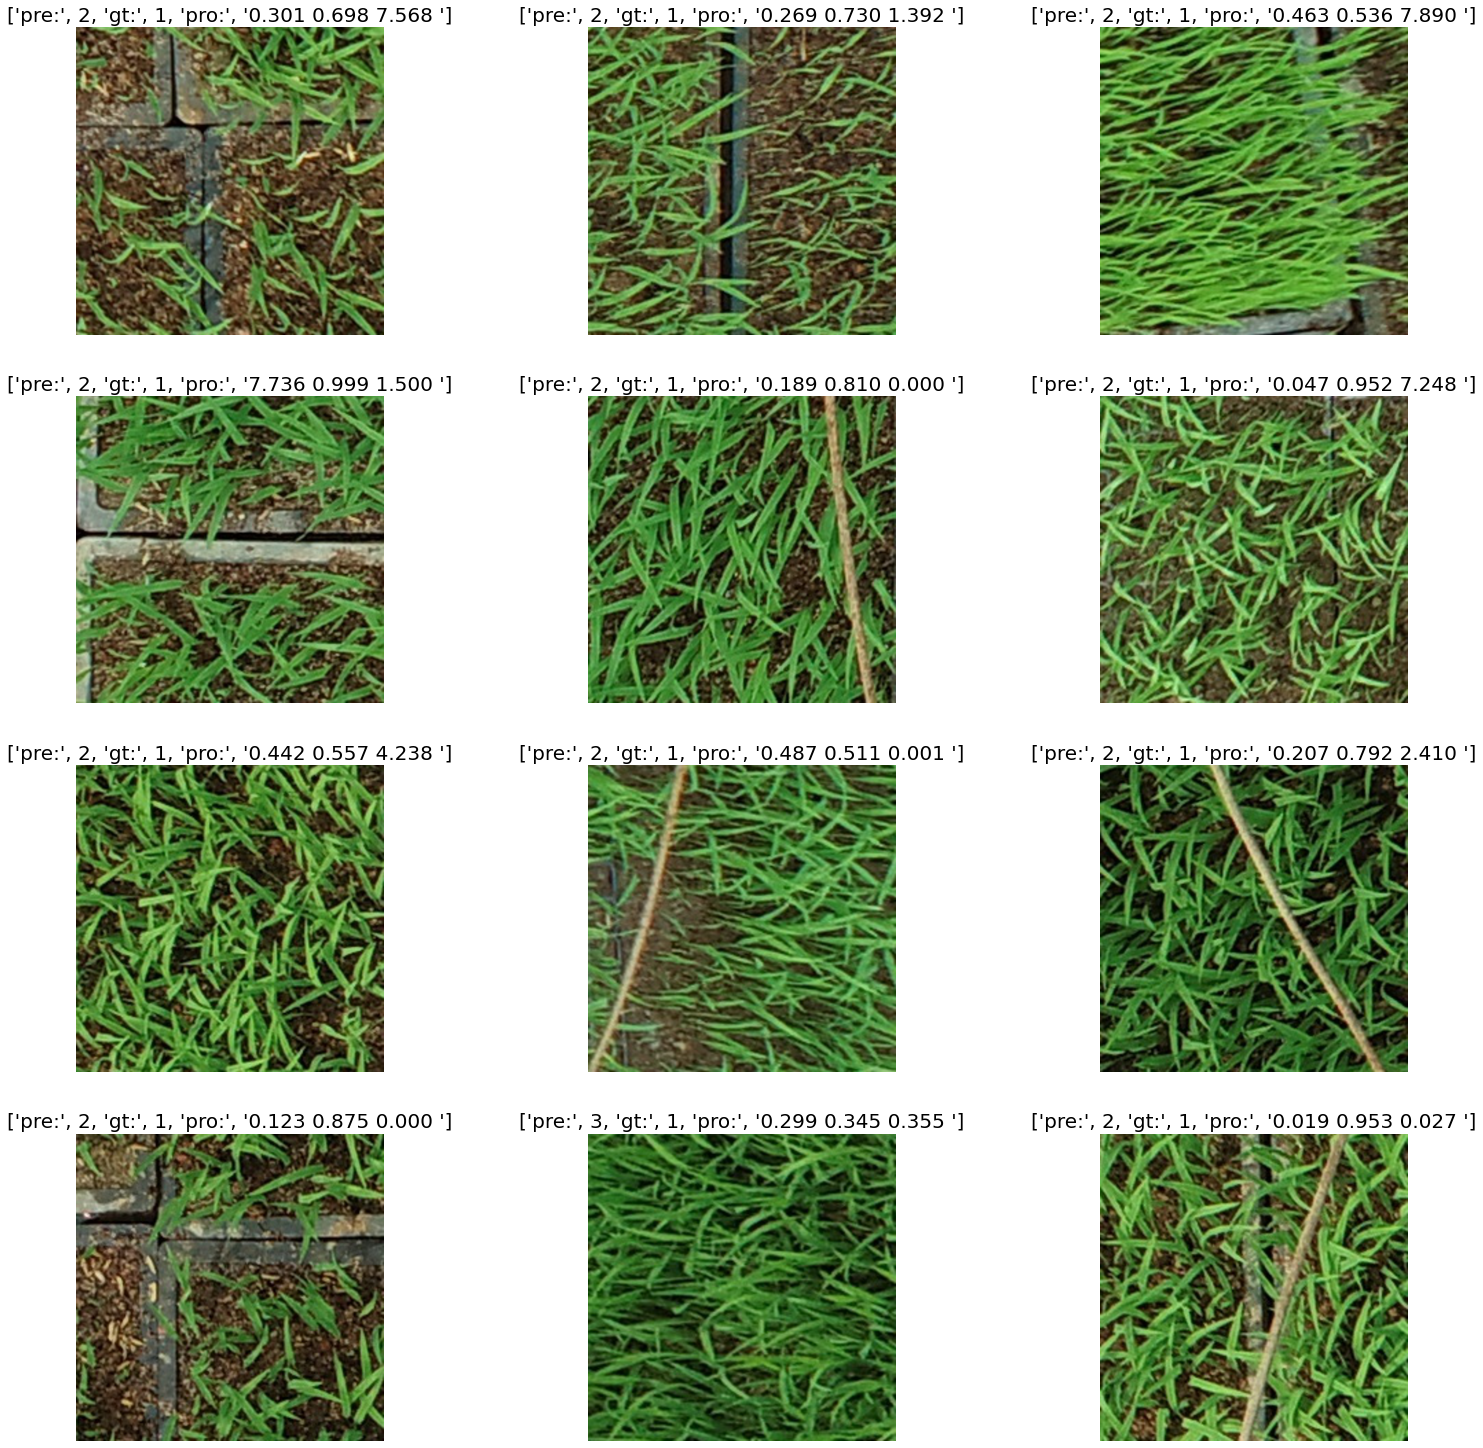

In [15]:
fig = plt.figure(figsize=(26,26))
a=1
img_scale = (600, 600)
num = min(len(misclass),12)

for i in range(num):
    img = Image.open(os.path.join(image_path, 'test' , misclass[i][1]))
    img = img.resize(img_scale)
    img = img.convert("RGB")
    plt.subplot(4,3,a)
    plt.axis('off')
    a+=1
    
    plt.title(['pre:',misclass[i][2],  # Prediction classification
               'gt:', misclass[i][3],  # Actual classification
               'pro:', ''.join( '%.5s ' %a for a in misclass[i][4] )], fontsize=20) # Probability
    plt.imshow(img)
plt.show()